In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lib.models as models
from lib.core.config import config
from lib.core.config import update_config
from lib.core.integral_loss import get_joint_location_result
from lib.utils.img_utils import convert_cvimg_to_tensor

from lib.utils.vis import drawskeleton, show3Dpose

# Load config file
You can specify the pretrained models, and other configuration parameters in `*.yaml` file and update the `cfg_file` parameter accordingly

In [2]:
cfg_file = 'experiments/mpii/valid.yaml'
update_config(cfg_file)

torch.backends.cudnn.benchmark = config.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = config.CUDNN.ENABLED

image_size = config.MODEL.IMAGE_SIZE[0]

/home/khw/바탕화면/VC_3d/EpipolarPose/lib/core/config.py:173: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


# Create model

In [3]:
model = models.pose3d_resnet.get_pose_net(config, is_train=False)
gpus = [int(i) for i in config.GPUS.split(',')]
model = torch.nn.DataParallel(model, device_ids=gpus).cuda()
print('Created model...')

checkpoint = torch.load(config.MODEL.RESUME)
model.load_state_dict(checkpoint)
model.eval()
print('Loaded pretrained weights...')

Created model...
Loaded pretrained weights...


# Read and prepocess a sample image

In [4]:
img_path = 'sample_images/0.jpg'
image = cv2.imread(img_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
image = cv2.resize(image, (image_size, image_size))

img_height, img_width, img_channels = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_patch = convert_cvimg_to_tensor(image)

mean = np.array([123.675, 116.280, 103.530])
std = np.array([58.395, 57.120, 57.375])
    
# apply normalization
for n_c in range(img_channels):
    if mean is not None and std is not None:
        img_patch[n_c, :, :] = (img_patch[n_c, :, :] - mean[n_c]) / std[n_c]
img_patch = torch.from_numpy(img_patch).cuda()

# Inference

In [5]:
preds = model(img_patch[None, ...])
preds = get_joint_location_result(image_size, image_size, preds)[0,:,:3]

# Visualize results

/home/khw/anaconda3/envs/epipolarpose/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/khw/anaconda3/envs/epipolarpose/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


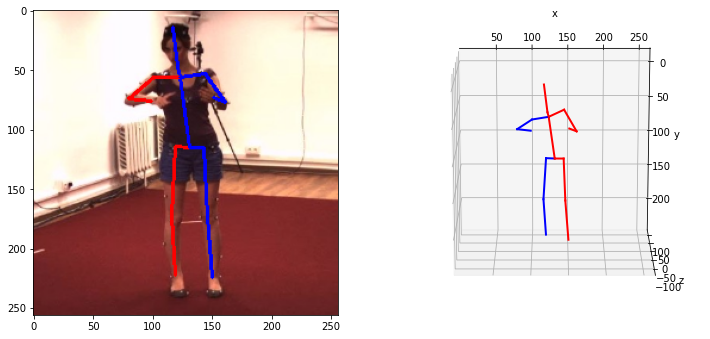

In [6]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot('121')
drawskeleton(image, preds, thickness=2,mpii=1)
ax.imshow(image)

ax = fig.add_subplot('122', projection='3d', aspect='auto')
show3Dpose(preds, ax, radius=128,mpii=1)
ax.view_init(-75, -90)